In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gym_bandits
import gym
import math

env = gym.make("BanditTenArmedGaussian-v0")

In [2]:
env.action_space

Discrete(10)

## Epsilon Greedy Policy

In [3]:
class EpsilonGreedyPolicy:
    def __init__(self):
        self.Q = self.initialize_zeros(10)
        self.sum_rewards = self.initialize_zeros(10)
        self.count = self.initialize_zeros(10)
    
    def initialize_zeros(self, num_arms):
        return np.zeros(num_arms)
    
    def epsilon_greedy(self, epsilon):
        if np.random.random() < epsilon:
            action = env.action_space.sample()
        else: 
            action = np.argmax(self.Q)  
        return action
    
    def pull_arm(self, num_rounds, epsilon):
        for i in range(num_rounds):
            
            # Select the arm using epsilon greedy
            arm = self.epsilon_greedy(epsilon)

            # Get the reward
            observation, reward, done, info = env.step(arm)

            # update the count of that arm
            self.count[arm] += 1

            # Sum the rewards obtained from the arm
            self.sum_rewards[arm]+=reward

            # calculate Q value which is the average rewards of the arm
            self.Q[arm] = self.sum_rewards[arm]/self.count[arm]
        
        print('Completed. The optimal arm is {}'.format(np.argmax(self.Q)))
    
    def check_Q(self):
        # print("The Q-values are:\n",self.Q)
        return self.Q
    
    def check_sum_rewards(self):
        # print("The rewards sum are:\n",self.sum_rewards)
        return self.sum_rewards
        
    def check_arm_count(self):
        # print("Counts of each arm:\n",self.count)
        return self.count

In [4]:
def random_play(arm):
    observation, reward, done, info = env.step(arm)
    print('Pull arm: ', arm)
    print('Observation: ', observation)
    print('Reward: ', reward)

In [7]:
random_play(5)

Pull arm:  5
Observation:  0
Reward:  -1.9261991110361945


In [5]:
num_epochs = 20000
epsilon_greedy_policy = EpsilonGreedyPolicy()
epsilon_greedy_policy.pull_arm(num_epochs, 0.5)
print()
Q_values = epsilon_greedy_policy.check_Q()
print("The Q-values are:\n",Q_values)
print()
rewards = epsilon_greedy_policy.check_sum_rewards()
print("The rewards sum are:\n", rewards)
print()
arm_count = epsilon_greedy_policy.check_arm_count()
print("Counts of each arm:\n", arm_count)
print()

Completed. The optimal arm is 4

The Q-values are:
 [-0.16671715 -0.8135422  -2.05550422 -1.21183482  1.60570438 -1.62818161
  1.1604779   0.31402643  0.62722729 -0.54485093]

The rewards sum are:
 [ -169.55134618  -791.576565   -2063.72623443 -1198.50463387
 17688.43940914 -1706.33432426  1159.31742204   303.03550397
   624.09115683  -541.58182546]

Counts of each arm:
 [ 1017.   973.  1004.   989. 11016.  1048.   999.   965.   995.   994.]



In [8]:
def plot_arm_count(arm_count):
    x = np.arange(10)
    freq = arm_count
    width = 0.8 # width of the bars
    fig, ax = plt.subplots()
    rects1 = ax.bar(x, freq, width, color='g')

    ax.set_ylabel('Counts')
    ax.set_xlabel('Arm Index')
    plt.xticks(np.arange(0, 10, 1.0))

    def autolabel(rects):
        # attach some text labels
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width()/2., 1.05*height,
                    '%d' % int(height),
                    ha='center', va='bottom')

    autolabel(rects1)

    plt.show()

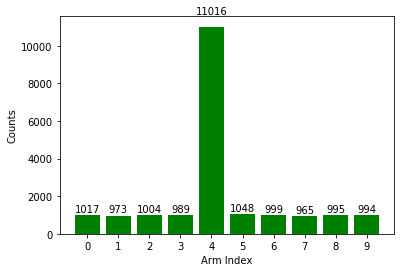

In [9]:
plot_arm_count(epsilon_greedy_policy.count)

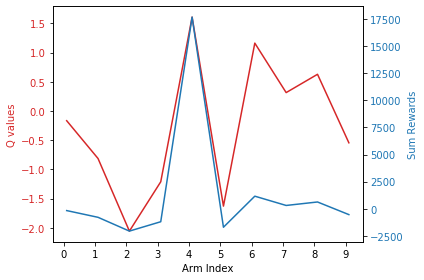

In [20]:
arm = np.arange(0.1, 10, 1)

fig, ax1 = plt.subplots()

color1 = 'tab:red'
ax1.set_xlabel('Arm Index')
ax1.set_ylabel('Q values', color=color1)
ax1.plot(arm, Q_values, color=color1, label='Q values')
ax1.tick_params(axis='y', labelcolor=color1)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color2 = 'tab:blue'
ax2.set_ylabel('Sum Rewards', color=color2) 
ax2.plot(arm, rewards, color=color2, label='Sum Rewards')
ax2.tick_params(axis='y', labelcolor=color2)

fig.tight_layout()
plt.xticks(np.arange(0, 10, 1.0))
plt.show()

#### How does the epsilon values affect the final selection of optimal arm?

When epsilon =  0.1
Completed. The optimal arm is 4


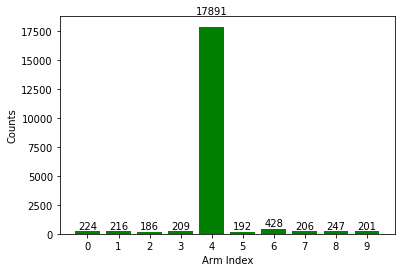

When epsilon =  0.3
Completed. The optimal arm is 4


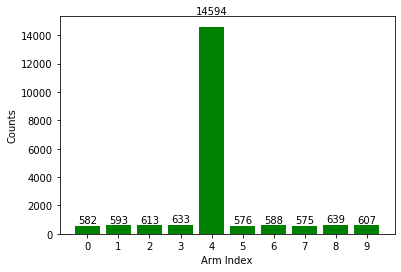

When epsilon =  0.6
Completed. The optimal arm is 4


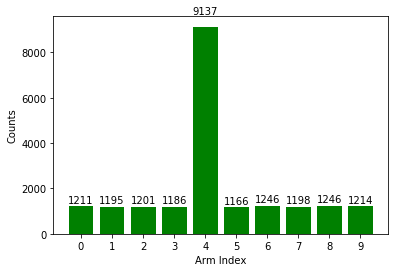

When epsilon =  0.9
Completed. The optimal arm is 4


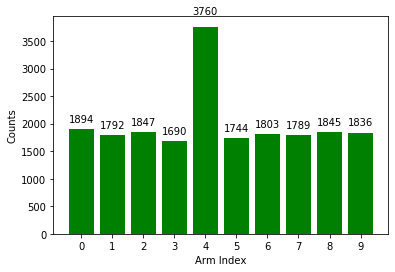

In [21]:
epsilon_values = [0.1, 0.3, 0.6, 0.9]
for ep in epsilon_values:
    print('When epsilon = ', ep)
    epsilon_greedy_policy = EpsilonGreedyPolicy()
    epsilon_greedy_policy.pull_arm(num_epochs, ep)
    arm_count = epsilon_greedy_policy.check_arm_count()
    plot_arm_count(arm_count)

#### Observation

1. The selection of optimal arm is always the same in the same game regardless the epsilon value. 
2. For epsilon value set at 0.1, it is follow greedy action which choose the arm that pay maximum reward. Therefore, the count of that arm selected is highest.
2. When epsilon value increased, all other non-best arms are also have been selected due to high exploration rate. Therefore, the count of that arm selected is increased.

## Softmax Exploration Policy

In [22]:
class SoftmaxExploration:
    def __init__(self):
        self.Q = self.initialize_zeros(10)
        self.sum_rewards = self.initialize_zeros(10)
        self.count = self.initialize_zeros(10)

    def initialize_zeros(self, num_arms):
        return np.zeros(num_arms)
    
    def softmax_probability(self, tau):
        total = sum([math.exp(val/tau) for val in self.Q])
        probs = [math.exp(val/tau)/total for val in self.Q]
        threshold = np.random.random()
        cumulative_prob = 0.0

        for i in range(len(probs)):
            cumulative_prob += probs[i]
            if (cumulative_prob > threshold):
                return i
        return np.argmax(probs)
    
    def pull_arm(self, num_rounds,temperature):
        for i in range(num_rounds):
            
            # Select the arm using softmax
            arm = self.softmax_probability(temperature)
            observation, reward, done, info = env.step(arm)
            self.count[arm] += 1
            self.sum_rewards[arm]+=reward
            self.Q[arm] = self.sum_rewards[arm]/self.count[arm]
        
        print('Completed. The optimal arm is {}'.format(np.argmax(self.Q)))
    
    def check_Q(self):
        # print("The Q-values are:\n",self.Q)
        return self.Q
    
    def check_sum_rewards(self):
        # print("The rewards sum are:\n",self.sum_rewards)
        return self.sum_rewards
        
    def check_arm_count(self):
        # print("Counts of each arm:\n",self.count)
        return self.count

In [23]:
num_epochs = 20000
softmax_policy = SoftmaxExploration()
softmax_policy.pull_arm(num_epochs,0.5)
print()
softmax_Q_values = softmax_policy.check_Q()
print("The Q-values are:\n",softmax_Q_values)
print()
softmax_rewards = softmax_policy.check_sum_rewards()
print("The rewards sum are:\n", softmax_rewards)
print()
softmax_arm_count = softmax_policy.check_arm_count()
print("Counts of each arm:\n", softmax_arm_count)
print()

Completed. The optimal arm is 4

The Q-values are:
 [-0.15084572 -0.72369748 -1.99110776 -1.20573275  1.59665385 -1.59945194
  1.1746587   0.17574191  0.61948797 -0.60473566]

The rewards sum are:
 [  -64.2602761    -75.9882353    -53.75990955   -69.93249957
 18616.98385476   -46.38410623  5869.76952007   132.33365508
  1128.08759474   -74.98722242]

Counts of each arm:
 [  426.   105.    27.    58. 11660.    29.  4997.   753.  1821.   124.]



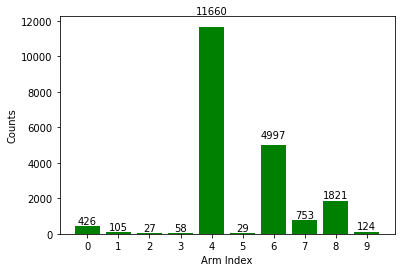

In [24]:
plot_arm_count(softmax_arm_count)

When epsilon =  0.1
Completed. The optimal arm is 3


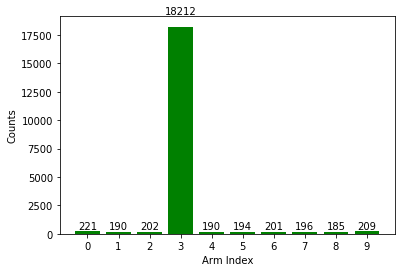

When epsilon =  0.2
Completed. The optimal arm is 3


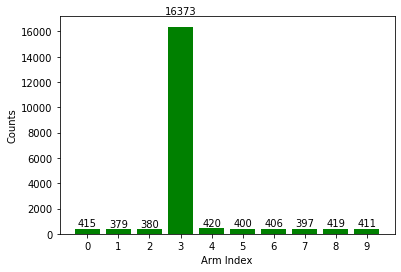

When epsilon =  0.30000000000000004
Completed. The optimal arm is 3


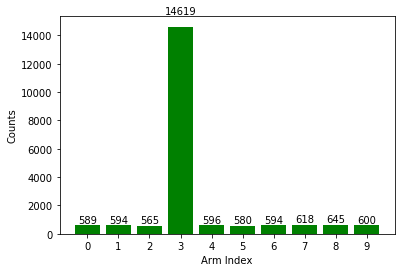

When epsilon =  0.4
Completed. The optimal arm is 3


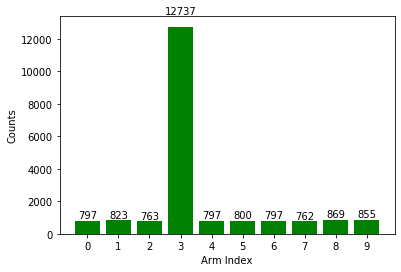

When epsilon =  0.5
Completed. The optimal arm is 3


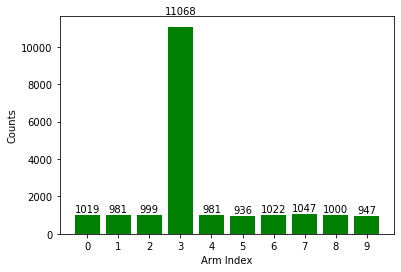

When epsilon =  0.6
Completed. The optimal arm is 3


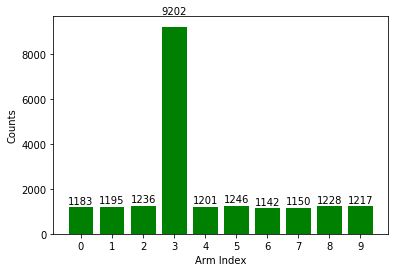

When epsilon =  0.7000000000000001
Completed. The optimal arm is 3


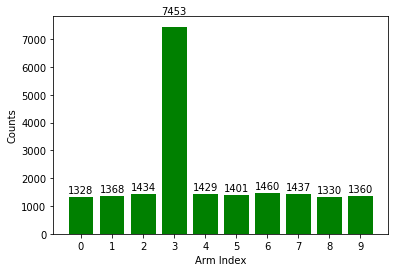

When epsilon =  0.8
Completed. The optimal arm is 3


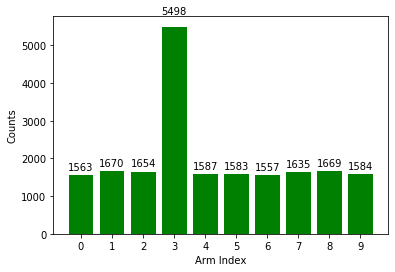

When epsilon =  0.9
Completed. The optimal arm is 3


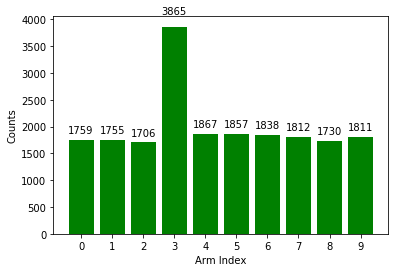

In [92]:
epsilon_values = np.arange(0.1,1,0.1)
for ep in epsilon_values:
    print('When epsilon = ', ep)
    epsilon_greedy_policy = EpsilonGreedyPolicy()
    epsilon_greedy_policy.pull_arm(num_epochs, ep)
    arm_count = epsilon_greedy_policy.check_arm_count()
    plot_arm_count(arm_count)

#### Observation

1. Similar to epsilon greedy policy, the selection of optimal arm is always the same in the same game regardless the temperature value, except when temperature is zero which caused the zero 
2. For epsilon value set at 0.1, it is follow greedy action which choose the arm that pay maximum reward. Therefore, the count of that arm selected is highest.
2. When epsilon value increased, all other non-best arms are also have been selected due to high exploration rate. Therefore, the count of that arm selected is increased.

## Upper Confidence Bound

For example, 
confidence interval of an arm is [0.3, 0.8], this indicate the range of mean value of that arm, the 0.3 is the lower
confidence bound, whereas 0.8 is the UCB. The UCB selects a machine that has a high UCB to explore.

In [122]:
class UpperConfidenceBound:
    def __init__(self):
        self.Q = self.initialize_zeros(10)
        self.sum_rewards = self.initialize_zeros(10)
        self.count = self.initialize_zeros(10)

    def initialize_zeros(self, num_arms):
        return np.zeros(num_arms)
    
    def UCB(self, iters):
        ucb = self.initialize_zeros(10)
        if iters < 10:
            return iters, None
        else:
            for arm in range(10):
                upper_bound = math.sqrt((2*math.log(sum(self.count))) / self.count[arm])
                ucb[arm] = self.Q[arm] + upper_bound

        return np.argmax(ucb), ucb
    
    def pull_arm(self, num_rounds):
        ucb_list = []
        for i in range(num_rounds):
            arm, updated_ucb = self.UCB(i)
            ucb_list.append(updated_ucb)
            observation, reward, done, info = env.step(arm)
            self.count[arm] += 1
            self.sum_rewards[arm]+=reward
            self.Q[arm] = self.sum_rewards[arm]/self.count[arm]
        
        print('Completed. The optimal arm is {}'.format(np.argmax(self.Q)))
        return ucb_list
    
    def check_Q(self):
        # print("The Q-values are:\n",self.Q)
        return self.Q
    
    def check_sum_rewards(self):
        # print("The rewards sum are:\n",self.sum_rewards)
        return self.sum_rewards
        
    def check_arm_count(self):
        # print("Counts of each arm:\n",self.count)
        return self.count

In [123]:
num_epochs = 20000
ucb = UpperConfidenceBound()
ucb_list = ucb.pull_arm(num_epochs)
print()
ucb_Q_values = ucb.check_Q()
print("The Q-values are:\n",ucb_Q_values)
print()
ucb_rewards = ucb.check_sum_rewards()
print("The rewards sum are:\n", ucb_rewards)
print()
ucb_arm_count = ucb.check_arm_count()
print("Counts of each arm:\n", ucb_arm_count)
print()

Completed. The optimal arm is 4

The Q-values are:
 [-0.16278968 -0.90657028 -2.61552853 -2.44495042  1.58834937 -1.32795279
  1.22527066  0.23857553  0.11580954 -0.29382766]

The rewards sum are:
 [-1.13952776e+00 -3.62628110e+00 -5.23105706e+00 -4.88990084e+00
  3.14826728e+04 -3.98385837e+00  1.61735727e+02  3.10148194e+00
  1.04228589e+00 -2.05679361e+00]

Counts of each arm:
 [7.0000e+00 4.0000e+00 2.0000e+00 2.0000e+00 1.9821e+04 3.0000e+00
 1.3200e+02 1.3000e+01 9.0000e+00 7.0000e+00]



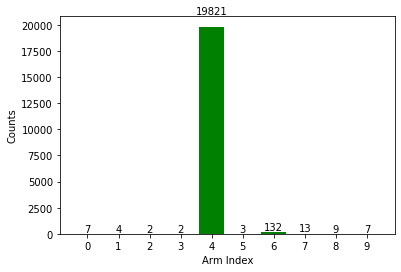

In [124]:
plot_arm_count(ucb_arm_count)

In [126]:
final_ucb_list = ucb_list[10:]
len(final_ucb_list)

19990

In [129]:
arm_ucb = [None] * 10
for ind in range(10):
    arm_ucb[ind] = [i[ind] for i in final_ucb_list]

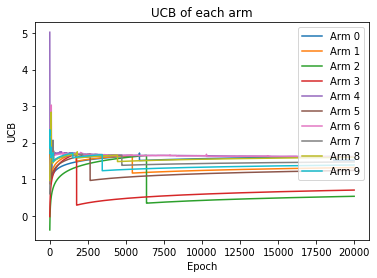

In [141]:
for i in range(10):
    plt.plot(arm_ucb[i], label='Arm %d' %(i))

plt.legend()
plt.title('UCB of each arm')
plt.xlabel('Epoch')
plt.ylabel('UCB')
plt.show()

#### Observation

1. Interestingly, the selected optimal arm has highest count while the other arms are much sheldom been selected.
2. In contrast to the previous methods, UCB select the arm which has high sum of average reward and upper confidence bound.
2. Per simple plotting, its shows that some of the arms have higher UCB and then decayed, the selected arm has highest peak UCB value initially.

## Thompson Sampling

In [147]:
class ThompsonSampling:
    def __init__(self):
        self.Q = self.initialize_zeros(10)
        self.sum_rewards = self.initialize_zeros(10)
        self.count = self.initialize_zeros(10)
        self.alpha = self.initialize_zeros(10)
        self.beta = self.initialize_zeros(10)

    def initialize_zeros(self, num_arms):
        return np.zeros(num_arms)
    
    def thompson_sampling(self, alpha, beta):
        samples = [np.random.beta(alpha[i]+1, beta[i]+1) for i in range(10)]
        
        return np.argmax(samples)
    
    def pull_arm(self, num_rounds):
        for i in range(num_rounds):
            arm = self.thompson_sampling(self.alpha,self.beta)
            observation, reward, done, info = env.step(arm)
            self.count[arm] += 1
            self.sum_rewards[arm]+=reward
            self.Q[arm] = self.sum_rewards[arm]/self.count[arm]

            # If it is a positive reward increment alpha
            if reward >0:
                self.alpha[arm] += 1
                
            # If it is a negative reward increment beta
            else:
                self.beta[arm] += 1

        print('Completed. The optimal arm is {}'.format(np.argmax(self.Q)))
    
    def check_Q(self):
        # print("The Q-values are:\n",self.Q)
        return self.Q
    
    def check_sum_rewards(self):
        # print("The rewards sum are:\n",self.sum_rewards)
        return self.sum_rewards
        
    def check_arm_count(self):
        # print("Counts of each arm:\n",self.count)
        return self.count

In [163]:
num_epochs = 20000
ts = ThompsonSampling()
ts_list = ts.pull_arm(num_epochs)
print()
ts_Q_values = ts.check_Q()
print("The Q-values are:\n",ts_Q_values)
print()
ts_rewards = ts.check_sum_rewards()
print("The rewards sum are:\n", ts_rewards)
print()
ts_arm_count = ts.check_arm_count()
print("Counts of each arm:\n", ts_arm_count)
print()

Completed. The optimal arm is 4

The Q-values are:
 [-0.25670941 -1.05169227 -2.6258325  -1.54596716  1.59051115 -2.07441054
  1.05174721  0.7617511   0.62512383 -1.23351008]

The rewards sum are:
 [-1.54025643e+00 -3.15507680e+00 -7.87749751e+00 -4.63790147e+00
  3.15891420e+04 -6.22323163e+00  7.04670631e+01  1.29497686e+01
  2.12542103e+01 -3.70053023e+00]

Counts of each arm:
 [6.0000e+00 3.0000e+00 3.0000e+00 3.0000e+00 1.9861e+04 3.0000e+00
 6.7000e+01 1.7000e+01 3.4000e+01 3.0000e+00]



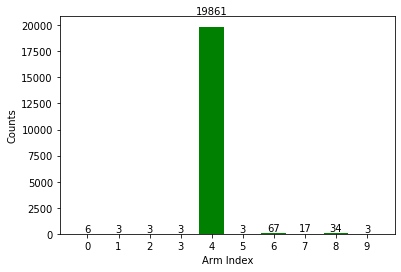

In [164]:
plot_arm_count(ts_arm_count)

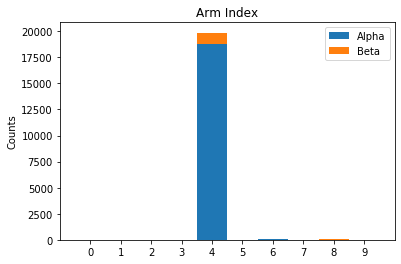

In [165]:
width = 1

fig, ax = plt.subplots()
x = np.arange(10)
  
ax.bar(x, ts.alpha, width, label='Alpha')
ax.bar(x, ts.beta, width, bottom=ts.alpha,label='Beta')

ax.set_ylabel('Counts')
ax.set_title('Arm Index')
ax.legend()

plt.xticks(np.arange(0, 10, 1.0))
plt.show()

#### Observation

1. Similar as UCB method, the selected optimal arm has highest selected count while the other arms are very small count number of selected.
2. The alpha and beta for selected arm are relatively higher compared to other arms since it is the arm that likely be selected.
3. The alpha which represented recieved positive reward count certainly much higher than beta that represented count of negative reward obtained.